# Imports

In [1]:
%matplotlib inline

import os
import sys
from ipywidgets import interact, FloatSlider

import dynaphos
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import math

from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos import cortex_models

sys.path.append(os.path.abspath(os.path.join('..')))

from utils import resize

import local_datasets
from torch.utils.data import Subset, DataLoader

from utils import (
    CustomSummaryTracker,
    dilation3x3,
    resize,
    tensor_to_rgb,
    undo_standardize,
)

import importlib

from time import time

# Face Data

In [2]:
importlib.reload(local_datasets)

<module 'local_datasets' from '/gpfs/home1/mappel/Dynaphos/viseon/local_datasets.py'>

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

cfg = load_config('../_config/exp-local/faces_boundary_supervised_phosphenes_no_decoder.yaml')
cfg['retinal_compression'] = True
cfg['data_directory'] = '../../data/face/LaPa'
cfg['base_config'] = '../_config/exp-local/params.yaml'
cfg['phosphene_map'] = '../_config/phosphene_maps/DefaultCoordinateMap_1000_phosphenes.pickle'
cfg['batch_size'] = 1
cfg['fov'] = 5
cfg['resolution'] = [256, 256]
cfg['output_scaling'] = 1.e-4
cfg['n_electrodes'] = 1024
params = dynaphos.utils.load_params(cfg['base_config'])
params['run']['batch_size'] = cfg['batch_size']

cfg['retinal_compression'] = True
cfg['imsize'] = [64, 64]
cfg['fov'] = 16
cfg['circular_mask'] = False

In [4]:
trainset, valset = local_datasets.get_lapa_dataset(cfg)

trainloader = DataLoader(trainset, batch_size=cfg['batch_size'], shuffle=True, drop_last=True)
valloader = DataLoader(valset, batch_size=cfg['batch_size'], shuffle=True, drop_last=True)

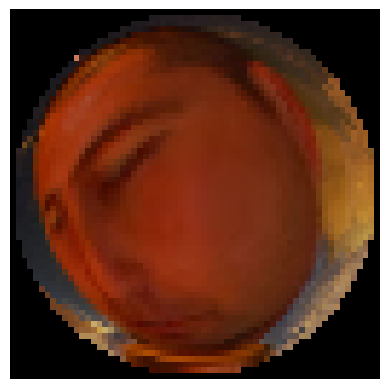

In [5]:
example_batch = next(iter(valloader))

plt.imshow(example_batch['image'][0].permute(1,2,0).cpu())
plt.axis('off')
plt.show()

# Simulator

In [6]:
def get_simulator(cfg, phosphene_coords=None):
    # initialise simulator

    params = dynaphos.utils.load_params(cfg['base_config'])
    params['run']['batch_size'] = cfg['batch_size']

    if phosphene_coords is None:
        n_phosphenes = cfg['n_electrodes']
        phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

    simulator = PhospheneSimulator(params, phosphene_coords)
    return simulator

n_phosphenes = cfg['n_electrodes']
params = dynaphos.utils.load_params(cfg['base_config'])
params['batch_size'] = 4
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = get_simulator(cfg, phosphene_coords=phosphene_coords)
cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
len(simulator.phosphene_maps)

1024

In [7]:
cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
print(f"Phosphene map size: {cfg['SPVsize']}")
N_PHOSPHENES = simulator.num_phosphenes
print(f"Number of phosphenes: {N_PHOSPHENES}")

Phosphene map size: torch.Size([256, 256])
Number of phosphenes: 1024


In [8]:
x, y = phosphene_coords._x, phosphene_coords._y
coords = torch.Tensor(np.array([x, y]))

In [9]:
reshape_square = np.sqrt(N_PHOSPHENES)

# if the sqrt is not an integer, we need to find the closest integer that is bigger
if int(reshape_square) != reshape_square:
    reshape_square = int(reshape_square) + 1
else:
    reshape_square = int(reshape_square)
    
reshape_square

32

In [10]:
# Function to update the plot based on the slider values
def update_plot(shift_x=0.5, shift_y=0.5, scale=20):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    shifted_image = torch.roll(face_image, int(shift_x * face_image.shape[-1]), dims=-1)
    shifted_image = torch.roll(shifted_image, int(shift_y * face_image.shape[-2]), dims=-2)
    
    # scale content and fit into original image size
    if scale > 0 and scale < 1.:
        scaled_image = F.interpolate(shifted_image, scale_factor=scale, mode='nearest')
        shifted_image = torch.zeros((1, 1, *cfg['imsize']), device=cfg['device'])
        shifted_image[0, 0, 
                    int((cfg['imsize'][0] - scaled_image.shape[-2]) / 2):int((cfg['imsize'][0] + scaled_image.shape[-2]) / 2), 
                    int((cfg['imsize'][1] - scaled_image.shape[-1]) / 2):int((cfg['imsize'][1] + scaled_image.shape[-1]) / 2)] = scaled_image
    elif scale == 0.: # no scaling
        shifted_image = torch.zeros((1, 1, *cfg['imsize']), device=cfg['device'])
    elif scale > 1.:
        scaled_image = F.interpolate(shifted_image, scale_factor=scale, mode='nearest')
        # crop
        shifted_image = scaled_image[:, :,
                    int((scaled_image.shape[-2] - cfg['imsize'][0]) / 2):int((scaled_image.shape[-2] + cfg['imsize'][0]) / 2),
                    int((scaled_image.shape[-1] - cfg['imsize'][1]) / 2):int((scaled_image.shape[-1] + cfg['imsize'][1]) / 2)]
        
    # Update the visual input display
    ax[0].imshow(shifted_image[0].permute(1,2,0).cpu().numpy(), cmap='gray')
    ax[0].set_title('Visual Input')
    ax[0].axis('off')
    
    # Update the phosphene display
    resized_image = resize(shifted_image, cfg['SPVsize'], interpolation='nearest')
    stimulation = simulator.sample_centers(resized_image.mean(1, keepdim=True)) * cfg['output_scaling']
    simulator.reset()
    phosphenes = simulator(stimulation).unsqueeze(1)
    
    ax[1].imshow(phosphenes.squeeze().detach().cpu().numpy(), cmap='gray')
    ax[1].set_title('Phosphenes')
    ax[1].axis('off')
    
    # Update the stimulation display
    stimulation_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
    stimulation_square.view(-1)[:N_PHOSPHENES] = stimulation

    ax[2].imshow(stimulation_square.cpu().numpy(), cmap='gray')
    ax[2].set_title('Stimulation')
    ax[2].axis('off')

    plt.show()


# Generate the circle image with the specified size
face_image = example_batch['contour'].to(cfg['device'])
face_image = dilation3x3(face_image)

# Display the interactive widgets
plot = interact(update_plot, 
         shift_x=FloatSlider(min=-0.5, max=0.5, step=0.001, value=0., description='Shift X'), 
         shift_y=FloatSlider(min=-0.5, max=0.5, step=0.001, value=0., description='Shift Y'),
         scale=FloatSlider(min=0.0, max=3.0, step=0.001, value=1., description='Scale'))

interactive(children=(FloatSlider(value=0.0, description='Shift X', max=0.5, min=-0.5, step=0.001), FloatSlide…

# Retinal Encoder

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out
    
def convlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None):
    layer = [
        nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

class Retinal_Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, n_electrodes=1024, out_scaling=1e-4, out_activation='relu'):
        super(Retinal_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        self.model = nn.Sequential(
                                    *convlayer(in_channels,8,3,1,1),
                                    *convlayer(8,16,3,2,1),
                                    *convlayer(16,32,3,2,1),
                                    *convlayer(32,64,3,2,1),
                                    *convlayer(64,128,3,2,1),
                                    *convlayer(128,256,3,2,1),
                                    *convlayer(256,512,3,2,1),
                                    *convlayer(512,1024,3,1,1),
                                    nn.AvgPool2d(2),
                                    self.out_activation
                                   )
        
        
        # self.model = nn.Sequential(
        #                             *convlayer(in_channels,8,3,2,1),
        #                             # *convlayer(8,16,3,2,1),
        #                             *convlayer(8,32,3,2,1),
        #                             # *convlayer(32,64,3,2,1),
        #                             *convlayer(32,128,3,2,1),
        #                             # *convlayer(128,256,3,2,1),
        #                             *convlayer(128,512,3,2,1),
        #                             *convlayer(512,1024,3,2,1),
        #                             nn.AvgPool2d(2),
        #                             self.out_activation
        #                            )

        # self.model = nn.Sequential(*convlayer(in_channels,8,3,1,1),
        #                            *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2)),
        #                            *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2)),
        #                            ResidualBlock(32, resample_out=None),
        #                            ResidualBlock(32, resample_out=None),
        #                            ResidualBlock(32, resample_out=None),
        #                            ResidualBlock(32, resample_out=None),
        #                            *convlayer(32,16,3,1,1),
        #                            nn.Conv2d(16,1,3,1,1),
        #                            nn.Flatten(),
        #                            nn.Linear(256,n_electrodes),
        #                            self.out_activation)
            
        
        self.n_electrodes = n_electrodes
        self.fc = None
            
    def forward(self, x):
        stimulation = self.model(x)
        return stimulation.squeeze(-1).squeeze(-1) * self.output_scaling


retinal_encoder = Retinal_Encoder(n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'], out_activation='relu').to(cfg['device'])
torch.use_deterministic_algorithms(False)

# test forward pass
output = retinal_encoder(torch.randn(1, 3, 64, 64).to(cfg['device']))

print('out size:', output.shape)
print(output.min(), output.max(), '\n')

# count number of parameters
print('Retinal Encoder Parameters:', sum(p.numel() for p in retinal_encoder.parameters()))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [56]:
retinal_encoder = Retinal_Encoder(n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'], out_activation='relu').to(cfg['device'])

input = torch.randn(1, 3, 64, 64).to(cfg['device'])

# Warm up the model (optional but recommended for more accurate timing)
for _ in range(10):
    _ = retinal_encoder(input)

def forward_pass():
    torch.cuda.synchronize()
    _ = retinal_encoder(input)
    torch.cuda.synchronize()

# time test 

start = time()
retinal_encoder(input)
end = time()

# print the input size, network architecture, time taken for forward pass, and number of parameters
print('Input size:', input.shape)
# print(retinal_encoder)
%timeit forward_pass()
print((end - start) * 1000, 'ms')
print('Retinal Encoder Parameters:', sum(p.numel() for p in retinal_encoder.parameters()))

Input size: torch.Size([1, 3, 64, 64])
1.62 ms ± 71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
0.9813308715820312 ms
Retinal Encoder Parameters: 5351208


### Jaap's encoder
Input size: torch.Size([1, 3, 128, 128]) \
3.72 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) \
5.002737045288086 ms \
Retinal Encoder Parameters: 1134969

Input size: torch.Size([1, 3, 64, 64]) \
4.11 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) \
3.983736038208008 ms \
Retinal Encoder Parameters: 348537

### Fully conv encoder
Input size: torch.Size([1, 3, 128, 128]) \
2.7 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) \
2.0041465759277344 ms \
Retinal Encoder Parameters: 6295368

Input size: torch.Size([1, 3, 64, 64]) \
1.62 ms ± 71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each) \
0.9813308715820312 ms \
Retinal Encoder Parameters: 5351208



## Small round of Training

In [456]:
cfg['batch_size'] = 2

trainloader = DataLoader(trainset, batch_size=cfg['batch_size'], shuffle=True, drop_last=True)

# Initialize the retinal encoder
cfg['output_scaling'] = 0.0002
retinal_encoder = Retinal_Encoder(out_activation='relu', in_channels=3, n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'])
retinal_encoder.to(cfg['device'])

phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = get_simulator(cfg, phosphene_coords)

# Define loss function
loss_fn = nn.L1Loss()
# loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(retinal_encoder.parameters(), lr=0.0009)

# Set deterministic algorithms off
torch.use_deterministic_algorithms(False)

for i in range(800):
    # Generate random image and make non differentiable
    batch = next(iter(trainloader))
    random_image, contour = batch['image'].to(cfg['device']), batch['contour'].to(cfg['device'])


    # Forward pass
    stimulation = retinal_encoder(random_image)
    simulator.reset()
    phosphenes = simulator(stimulation)
    simulator.reset()
    phosphene_centers = simulator.sample_centers(phosphenes)
    
    
    # Define target
    resized = resize(contour.float(), cfg['SPVsize'])
    simulator.reset()
    target = simulator.sample_centers(resized.mean(1, keepdim=True))
    simulator.reset()
    target_stimulus = simulator.sample_stimulus(resized.mean(1, keepdim=True)*cfg['output_scaling'])

    # Calculate loss
    # loss = loss_fn(phosphene_centers, target)
    loss = loss_fn(stimulation, target_stimulus)

    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 25 == 0:
        clear_output(wait=True)

        # print(f'Epoch {i} Loss: {loss.item()}')
        # show input image and phosphenes, and combined/overlayed image, target

        fig, ax = plt.subplots(2, 4, figsize=(22, 12))
        ax[0, 0].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 0].set_title('Visual Input')

        # phosphene image
        ax[0, 1].imshow(phosphenes[0].detach().cpu().numpy(), cmap='gray')
        ax[0, 1].axis('off')
        ax[0, 1].set_title('Phosphenes')

        # combined image
        ax[0, 2].imshow(resized[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0, 2].imshow(phosphenes[0].detach().cpu().numpy(), cmap='gray', alpha=0.5)
        ax[0, 2].axis('off')
        ax[0, 2].set_title('Combined Image')
    
        # target
        simulator.reset()
        out = simulator(target_stimulus)[0]
        ax[0, 3].imshow(out.detach().cpu().numpy(), cmap='gray')
        ax[0, 3].axis('off')
        ax[0, 3].set_title('Target')

        # 1,0 text block with training stats
        ax[1, 0].text(0.1, 0.5, f'Epoch {i} Loss: {loss.item()}', fontsize=12, ha='left')
        ax[1, 0].text(0.1, 0.4, f'Max Stimul: {stimulation.max().item()}', fontsize=12, ha='left')
        ax[1, 0].text(0.1, 0.3, f'Max Target: {target_stimulus.max().item()}', fontsize=12, ha='left')
        ax[1, 0].axis('off')
        
        # Create a square stimulation grid with a mask
        stimulation_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
        stimulation_square.view(-1)[:N_PHOSPHENES] = stimulation[0]

        stimulation_target_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
        stimulation_target_square.view(-1)[:N_PHOSPHENES] = target[0]

        ax[1, 1].imshow(stimulation_square.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1.0000e-04)
        ax[1, 1].set_title('Neural encoded Stimulation')
        ax[1, 1].axis('off')

        ax[1, 2].axis('off')

        ax[1, 3].imshow(stimulation_target_square.cpu().numpy(), cmap='gray', vmin=0, vmax=1.0000e-04)
        ax[1, 3].set_title('Target Stimulation')
        ax[1, 3].axis('off')

        plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 4.00 GiB total capacity; 3.29 GiB already allocated; 0 bytes free; 3.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF